In [5]:
#Загружаем библиотеки

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
import os
print ("Ok")

Ok


In [2]:
#Загружаем датафрейм
frame = pd.read_csv('Gosloto_6x45.csv', header=0, sep=';')
frame

,tiraz,datetime,1-number,2-number,3-number,4-number,5-number,6-number
0,1,10.11.2008 08:50,15,17,22,23,25,33
1,2,13.11.2008 08:50,23,29,44,19,24,45
2,3,17.11.2008 08:50,38,7,3,45,26,4
3,4,20.11.2008 08:50,31,26,44,37,40,27
4,5,24.11.2008 08:50,16,17,12,21,23,35
...,...,...,...,...,...,...,...,...
5424,5425,13.10.2020 11:00,18,7,16,23,37,43
5425,5426,13.10.2020 23:00,15,13,35,33,34,28
5426,5427,14.10.2020 11:00,27,44,40,29,41,25
5427,5428,14.10.2020 23:00,1,10,33,37,40,44


In [3]:
# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz', 'jackpot'], axis=1).astype(float)

KeyError: "['jackpot'] not found in axis"

<AxesSubplot:>

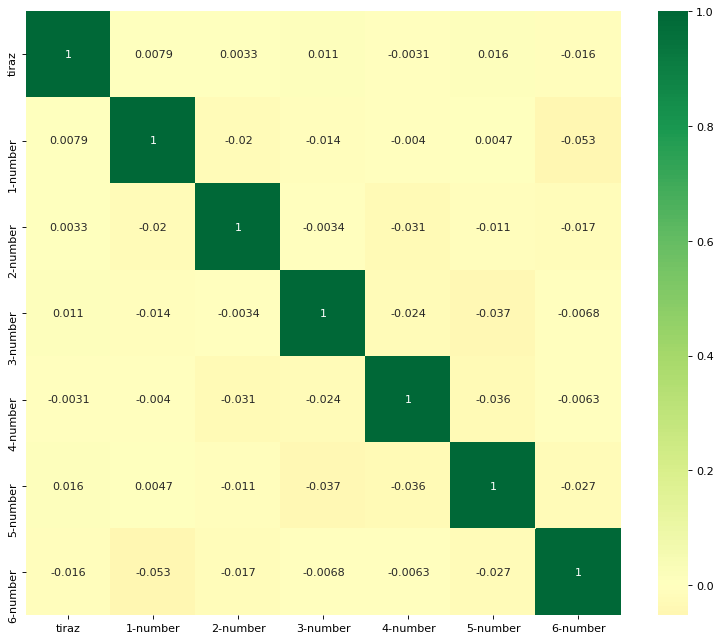

In [6]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(frame.corr(), xticklabels=frame.corr().columns, yticklabels=frame.corr().columns, cmap='RdYlGn', center=0, annot=True)

In [7]:
frame.describe()

,tiraz,1-number,2-number,3-number,4-number,5-number,6-number
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,2715.000000,22.982133,22.946952,23.113096,22.815620,23.348499,23.023577
std,1567.361637,13.006087,13.174812,12.846011,13.067398,13.046193,12.839588
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1358.000000,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000
50%,2715.000000,23.000000,23.000000,23.000000,22.000000,24.000000,23.000000
75%,4072.000000,34.000000,35.000000,34.000000,34.000000,35.000000,34.000000
max,5429.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000


In [10]:
a = frame["1-number"].to_numpy()
b = frame["2-number"].to_numpy()
c = frame["3-number"].to_numpy()
d = frame["4-number"].to_numpy()
e = frame["5-number"].to_numpy()
f = frame["6-number"].to_numpy()
# for numa in a:
#     np.append(allnum, [numa])
con = np.stack([a, b, c,d,e,f], axis=1)
con_r = con.reshape(32574,)

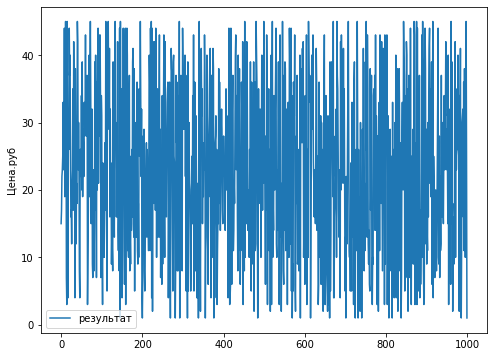

In [11]:
start = 0 #С какой точки начинаем
step = con_r.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
#chanelNames = list(allnum.columns)
plt.plot(con_r[0:1000],
          label="результат")
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [12]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [96]:
TRAIN_SPLIT = 40000
tf.random.set_seed(13)

**Прогнозирование на основе одномерного временного ряда**



In [97]:
con_r = np.array(range(0,60000,1))
#con_r = np.random.randint(0,45,60000).reshape(10000,6)

uni_data = con_r
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

# нормализация тензора
#uni_data = tf.keras.utils.normalize(con_r, axis=-1, order=2)

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге по времени.

In [98]:
univariate_past_history = 200
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.73200751]
 [-1.7319209 ]
 [-1.7318343 ]
 [-1.7317477 ]
 [-1.7316611 ]
 [-1.73157449]
 [-1.73148789]
 [-1.73140129]
 [-1.73131469]
 [-1.73122808]
 [-1.73114148]
 [-1.73105488]
 [-1.73096828]
 [-1.73088167]
 [-1.73079507]
 [-1.73070847]
 [-1.73062187]
 [-1.73053526]
 [-1.73044866]
 [-1.73036206]
 [-1.73027546]
 [-1.73018885]
 [-1.73010225]
 [-1.73001565]
 [-1.72992905]
 [-1.72984244]
 [-1.72975584]
 [-1.72966924]
 [-1.72958264]
 [-1.72949603]
 [-1.72940943]
 [-1.72932283]
 [-1.72923623]
 [-1.72914962]
 [-1.72906302]
 [-1.72897642]
 [-1.72888982]
 [-1.72880321]
 [-1.72871661]
 [-1.72863001]
 [-1.72854341]
 [-1.7284568 ]
 [-1.7283702 ]
 [-1.7282836 ]
 [-1.728197  ]
 [-1.72811039]
 [-1.72802379]
 [-1.72793719]
 [-1.72785058]
 [-1.72776398]
 [-1.72767738]
 [-1.72759078]
 [-1.72750417]
 [-1.72741757]
 [-1.72733097]
 [-1.72724437]
 [-1.72715776]
 [-1.72707116]
 [-1.72698456]
 [-1.72689796]
 [-1.72681135]
 [-1.72672475]
 [-1.72663815]
 [-1.72655155]
 [-1.72646

Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.


<module 'matplotlib.pyplot' from 'c:\\users\\gryaznevdy\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

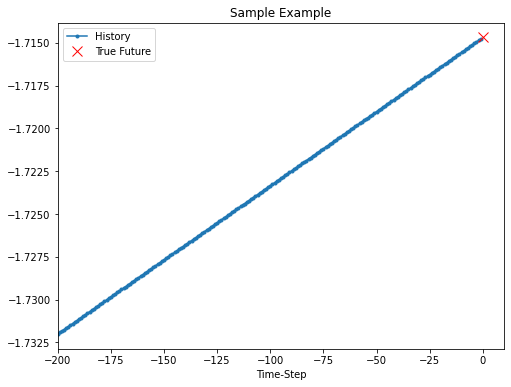

In [99]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.

<module 'matplotlib.pyplot' from 'c:\\users\\gryaznevdy\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

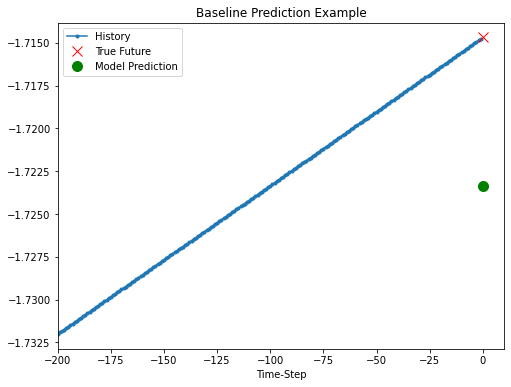

In [100]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Далее с помощью `[tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=ru)` выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

In [101]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [102]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(10)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

print(x_train_uni.shape)

(256, 10)
(39800, 200, 1)


In [103]:
EVALUATION_INTERVAL = 20
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/20
20/20 [==============================] - 35s 2s/step - loss: 0.4480 - val_loss: 1.4906

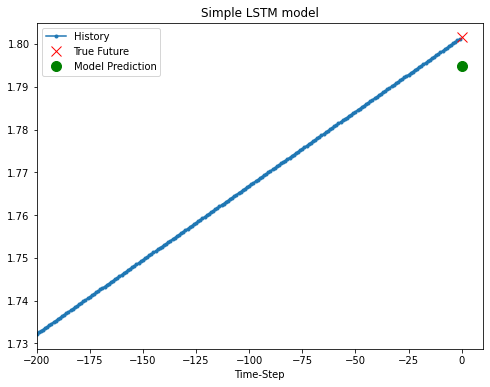

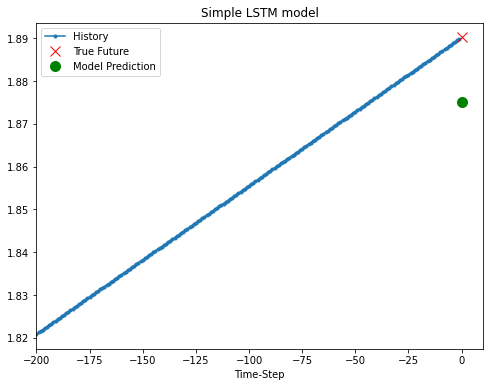

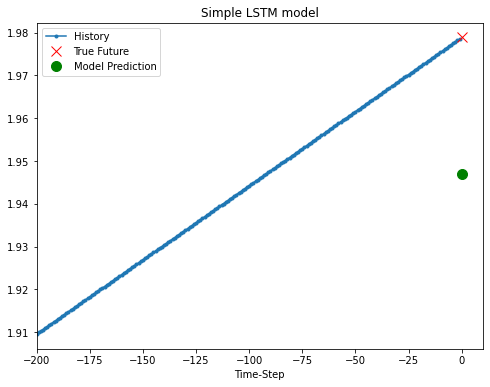

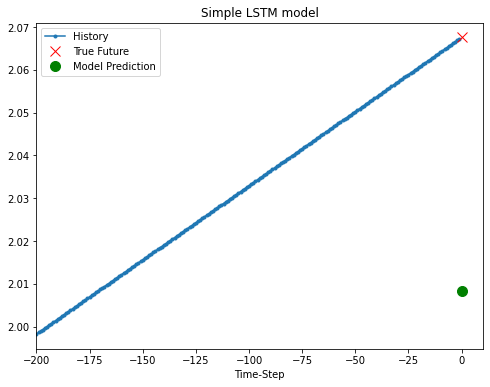

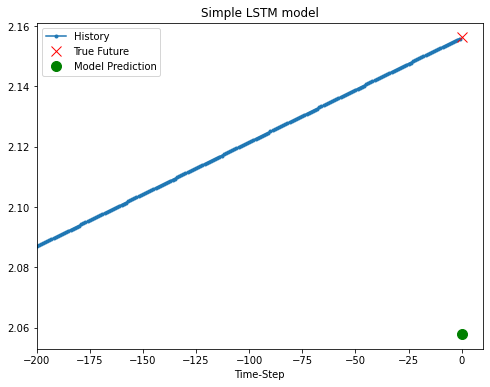

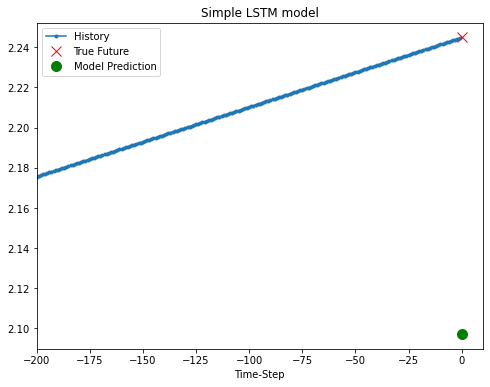

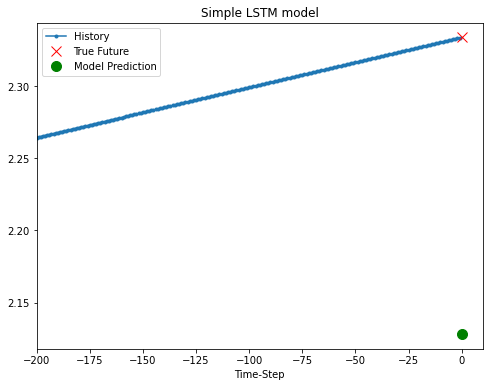

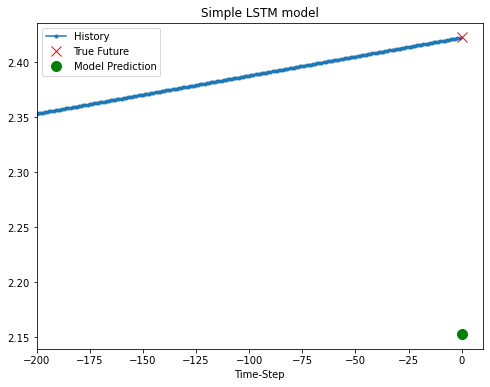

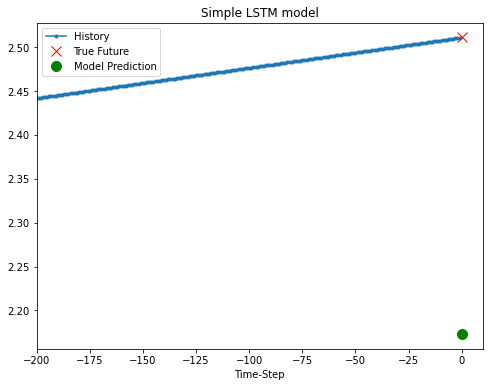

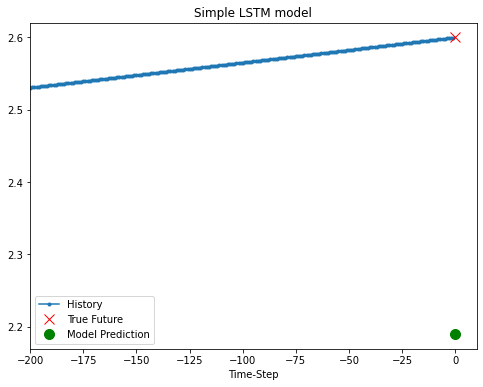

In [93]:
for x, y in val_univariate.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [110]:
print ( simple_lstm_model.predict(x)[:10])

SyntaxError: invalid syntax (<ipython-input-110-55f7e85c9bb0>, line 1)

In [108]:
# Создаем граф
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Создаем сессию с log_device_placement установленным в True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Выполняем операцию.
print(sess.run(c))